# Test Alpha Earth Embeddings

In [36]:
import os
import json
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

In [39]:
data_dir = '/home/nus/workspace/datasets/mangroves/alpha_earth'
mangrove_file = os.path.join(data_dir, 'mangrove_embeddings.csv')
terrestrial_file = os.path.join(data_dir, 'terrestrial_embeddings.csv')
water_file = os.path.join(data_dir, 'water_embeddings.csv')

df_mangrove = pd.read_csv(mangrove_file)
df_terrestrial = pd.read_csv(terrestrial_file)
df_water = pd.read_csv(water_file)

print(f'Mangrove embeddings shape:    {df_mangrove.shape}')
print(f'Terrestrial embeddings shape: {df_terrestrial.shape}')
print(f'Water embeddings shape:       {df_water.shape}')

Mangrove embeddings shape:    (100000, 74)
Terrestrial embeddings shape: (98991, 74)
Water embeddings shape:       (43640, 74)


In [42]:
X_mangroves = df_mangrove.loc[:, 'A00':'A63'].values
x_mangroves = df_mangrove.loc[:, 'x'].values
y_mangroves = df_mangrove.loc[:, 'y'].values

X_terrestrial = df_terrestrial.loc[:, 'A00':'A63'].values
x_terrestrial = df_terrestrial.loc[:, 'x'].values
y_terrestrial = df_terrestrial.loc[:, 'y'].values

X_water = df_water.loc[:, 'A00':'A63'].values
x_water = df_water.loc[:, 'x'].values
y_water = df_water.loc[:, 'y'].values

print(f'Mangroves shape:   {X_mangroves.shape}')
print(f'Terrestrial shape: {X_terrestrial.shape}')
print(f'Water shape:       {X_water.shape}')

Mangroves shape:   (100000, 64)
Terrestrial shape: (98991, 64)
Water shape:       (43640, 64)


In [43]:
C_mangroves = X_mangroves.mean(axis=0)
C_terrestrial = X_terrestrial.mean(axis=0)
C_water = X_water.mean(axis=0)

C_middle_MT = ((C_mangroves + C_terrestrial) / 2).reshape(1, -1)
C_middle_MW = ((C_mangroves + C_water) / 2).reshape(1, -1)
C_middle_TW = ((C_terrestrial + C_water) / 2).reshape(1, -1)

C_middle_MT.shape, C_middle_MW.shape, C_middle_TW.shape

((1, 64), (1, 64), (1, 64))

### Mangrove terreste + Eau = ?

### Plot

Text(0, 0.5, 'Y Coordinate')

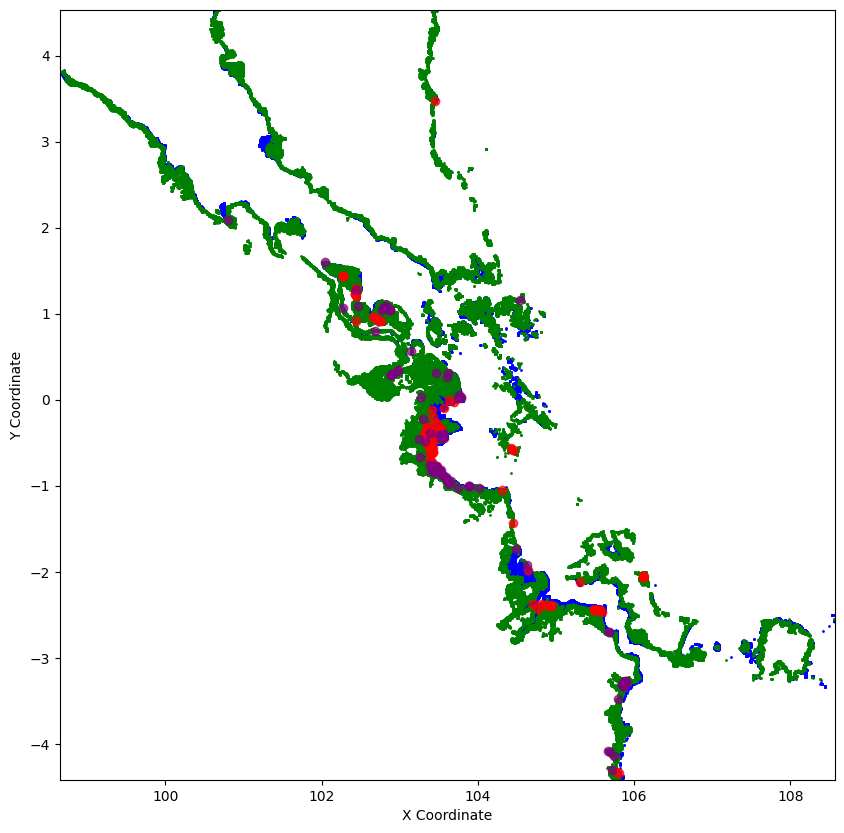

In [25]:
# bbox 
xmin, xmax, ymin, ymax = x_mangroves.min(), x_mangroves.max(), y_mangroves.min(), y_mangroves.max()

# plot the correspond area on a map
plt.figure(figsize=(10, 10))
plt.scatter(x_mangroves, y_mangroves, c='blue', s=1, label='Mangroves')
plt.scatter(x_terrestrial, y_terrestrial, c='green', s=1, label='Terrestrial')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Take the N closest points to the middle centroid
N = 100

idx_mangroves_sorted = np.argsort(dist_M2C, axis=0)[:N].flatten()
idx_terrestrial_sorted = np.argsort(dist_T2C, axis=0)[:N].flatten()
x_mangroves_N = x_mangroves[idx_mangroves_sorted]
y_mangroves_N = y_mangroves[idx_mangroves_sorted]
x_terrestrial_N = x_terrestrial[idx_terrestrial_sorted]
y_terrestrial_N = y_terrestrial[idx_terrestrial_sorted]

# Plot the N closest points on a scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(x_mangroves_N, y_mangroves_N, color='red', label='Mangroves', alpha=0.7)
plt.scatter(x_terrestrial_N, y_terrestrial_N, color='purple', label='Terrestrial', alpha=0.7)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

### Save

In [ ]:
data = {
    "mangroves": [{
        "x": x,
        "y": y
    } for x, y in zip(x_mangroves_N, y_mangroves_N)],   
    "terrestrial": [{
        "x": x,
        "y": y
    } for x, y in zip(x_terrestrial_N, y_terrestrial_N)]
}

def square_polygon(lon, lat, half_size_deg):
    # create a tiny square in degrees around the point
    return {
        "type": "Polygon",
        "coordinates": [[
            [lon - half_size_deg, lat - half_size_deg],
            [lon - half_size_deg, lat + half_size_deg],
            [lon + half_size_deg, lat + half_size_deg],
            [lon + half_size_deg, lat - half_size_deg],
            [lon - half_size_deg, lat - half_size_deg]
        ]]
    }

# half_size_deg: ~0.0005 deg ≈ 55 m at equator (tweak as needed)
half_size_deg = 0.0005

def to_fc_polygons(points, props):
    return {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": props,
                "geometry": square_polygon(p["x"], p["y"], half_size_deg)
            }
            for p in points
        ]
    }

mangroves_fc = to_fc_polygons(data["mangroves"], {"class": "mangrove"})
terrestrial_fc = to_fc_polygons(data["terrestrial"], {"class": "terrestrial"})

with open("mangroves_polygons.geojson", "w") as f:
    json.dump(mangroves_fc, f)

with open("terrestrial_polygons.geojson", "w") as f:
    json.dump(terrestrial_fc, f)